# Research about spike and slab for vb
## Background
+ In this study, we show how the approximated spike and slab prior gives a model selection.
    + Especially, we consider about linear regression case.
    
+ To update the result, we utilized a stochastic gradeient descent for vb

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.stats import wishart, norm
from scipy.special import gammaln, digamma, logsumexp
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt

# problem settings

In [3]:
data_seed = 20210626
n = 200
M = 400

N = 1000

In [4]:
true_p = 0.7

In [5]:
true_w = np.random.normal(size=M, scale=3)
zero_ind = np.sort(np.random.dirichlet(np.ones(M), size=1).squeeze().argsort()[:np.floor(true_p * M).astype(int)])
true_w[zero_ind] = 0

In [6]:
# X_base = np.random.uniform(-1, 1, size=n)
# train_X = X_base[:,np.newaxis]**(np.arange(M)[np.newaxis,:])
train_X = np.random.uniform(-1,1, size=(n, M))
train_Y = train_X@true_w + np.random.normal(size=n)

In [7]:
# X_base = np.random.uniform(-1, 1, size=N)
# test_X = X_base[:,np.newaxis]**(np.arange(M)[np.newaxis,:])
test_X = np.random.uniform(-1,1, size=(N, M))
test_Y = test_X@true_w + np.random.normal(size=N)

In [8]:
true_w

array([-1.97314273,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.9651663 ,  0.        ,  0.        ,  0.        ,
        0.        ,  2.99459122,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  3.99160088,  0.        ,
        0.8728184 ,  0.        ,  0.        , -2.65582034,  0.        ,
        0.        , -2.96482766,  0.        ,  0.        , -1.63057249,
        0.        , -2.52426982, -4.77307043, -1.38495415,  0.        ,
        1.14324722,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.84717945,  0.        ,  0.        ,  6.55980258,
        0.        ,  5.21483462,  0.        , -4.76751668,  5.46651669,
        0.        ,  0.        ,  0.        ,  6.62280425,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  2.08620137,  1.06671506, -0.36835393,
        0.        ,  0.        ,  0.        ,  1.36651802, -3.58

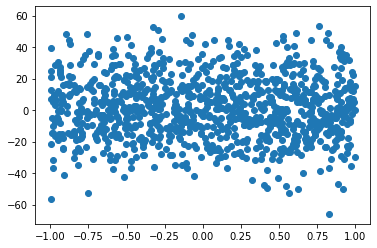

In [9]:
plt.scatter(test_X[:,1], test_Y)

# Learning part

## learning settings


In [10]:
log_normal_func = lambda x, sigma: -np.log(2*np.pi*sigma) - x/sigma/2

In [17]:
pri_alpha = 1
pri_beta = 1
pri_gamma = 0.0001
pri_delta_c = 0.005
approx_delta_func = lambda x, c: np.exp(-x**2/c/2)/np.sqrt(2*np.pi*c)
# approx_delta_log_func = lambda x, c: -np.log(2*np.pi*c)/2 - x/c/2

iteration = 3000
rho = 1
learning_seed = 20210628

tol = 1e-5

step = 100

In [18]:
np.random.seed(learning_seed)

## initialization

In [19]:
est_alpha=np.random.gamma(shape=1, size=1).squeeze()
est_beta=np.random.gamma(shape=1, size=1).squeeze()
est_sigma = np.linalg.inv(wishart.rvs(df=M+1, scale=np.eye(M), size=1))
est_mu = np.random.normal(size=M)

## main learning

In [20]:
def calc_energy(
    train_X: np.ndarray, train_Y: np.ndarray,
    est_alpha: float, est_beta: float, est_mu: np.ndarray, est_sigma: np.ndarray, 
    est_h_xi: np.ndarray, est_z_xi: np.ndarray,
    pri_alpha: float, pri_beta: float, pri_gamma: float, pri_delta_c: float=0.001
):
    (n, M) = train_X.shape
    
    sum_alpha_beta = est_alpha+est_beta
    eta_p1 = digamma(est_alpha)-digamma(est_alpha+est_beta)
    eta_p2 = digamma(est_beta)-digamma(est_alpha+est_beta)
    eta_m2 = np.outer(est_mu, est_mu) + est_sigma
    
    current_h_xi = np.vstack([
        eta_p1+log_normal_func(np.diag(eta_m2), pri_delta_c),
        eta_p2+norm.logpdf(np.diag(eta_m2), loc=0, scale=1/pri_gamma**2)
    ]).T
    
    KL_p = (est_alpha-1)*(eta_p1)+(est_beta-1)*(eta_p2)-(pri_alpha-1)*eta_p1-(pri_beta-1)*eta_p2\
    +gammaln(est_alpha+est_beta)-gammaln(est_alpha)-gammaln(est_beta)-gammaln(pri_alpha+pri_beta)+gammaln(pri_alpha)+gammaln(pri_beta)
    
    KL_m = -0.5*M-0.5*M*np.log(2*np.pi)+0.5*np.linalg.slogdet(est_sigma)[1]\
    - logsumexp(est_h_xi).sum() + (est_z_xi * (current_h_xi - est_h_xi)).sum()
    
    loss_Y = 0.5*n*np.log(2*np.pi) + 0.5*((train_Y-train_X@est_mu)**2).sum() + 0.5*np.trace(train_X.T@train_X@est_sigma)
    
    return (KL_p+KL_m+loss_Y), KL_p, KL_m, loss_Y

In [21]:
prev_energy = np.inf
for ite in range(iteration):
    pri_delta_c_t = pri_delta_c/(ite+1)
#     pri_delta_c_t = pri_delta_c
#     pri_delta_c_t = pri_delta_c if ite == 0 else (est_z_xi[:,0]*np.diag(eta_m2)).sum() / est_z_xi[:,0].sum()
    
    ### transform to natural parameters
    theta_p1 = est_alpha-1
    theta_p2 = est_beta-1
    theta_m1 = np.linalg.solve(est_sigma, est_mu)
    theta_m2 = -np.linalg.inv(est_sigma)/2

    ### set expectation parameters
    eta_p1 = digamma(est_alpha) - digamma(est_alpha+est_beta)
    eta_p2 = digamma(est_beta) - digamma(est_alpha+est_beta)
    eta_m1 = est_mu
    eta_m2 = est_sigma + np.outer(est_mu, est_mu)

    ### update local parameter
    est_h_xi = np.vstack([
        eta_p1+log_normal_func(np.diag(eta_m2), sigma=pri_delta_c_t),
        eta_p2+log_normal_func(np.diag(eta_m2), sigma=1/pri_gamma),
    ]).T

    est_z_xi = np.exp(est_h_xi - logsumexp(est_h_xi, axis=1, keepdims=True))

    ### derivative of expectation parameters
    n_z = est_z_xi.sum(axis=0)
    dFdeta_p1 = theta_p1 - n_z[0] - (pri_alpha - 1)
    dFdeta_p2 = theta_p2 - n_z[1] - (pri_alpha - 1)
    dFdeta_m1 = theta_m1 - train_X.T@train_Y
    dFdeta_m2 = theta_m2 + 0.5*train_X.T@train_X + (np.diag(est_z_xi[:,0]))/(2*pri_delta_c_t) + (np.diag(est_z_xi[:,1]))/2*pri_gamma

    ### update global parameters
    rho_t=rho/(ite+1)
    theta_p1 -= rho_t*dFdeta_p1
    theta_p2 -= rho_t*dFdeta_p2
    theta_m1 -= rho_t*dFdeta_m1
    theta_m2 -= rho_t*dFdeta_m2

    ### transform to original parameters
    est_alpha = theta_p1 + 1
    est_beta = theta_p2 + 1
    est_sigma = -0.5*np.linalg.inv(theta_m2)
    est_mu = est_sigma @ theta_m1

    energy = calc_energy(
            train_X, train_Y,
            est_alpha, est_beta, est_mu, est_sigma,
            est_h_xi, est_z_xi,
            pri_alpha, pri_beta, pri_gamma, pri_delta_c_t
    )[0]
    
    if ite%step == 0:
        print(energy, dFdeta_p1, dFdeta_p2, (dFdeta_m1**2).sum(), (dFdeta_m2**2).sum())
#     print("delta variance: ", (est_z_xi[:,0]*np.diag(eta_m2)).sum() / est_z_xi[:,0].sum())

    if np.abs(energy - prev_energy) < tol:
        break
    else:
        prev_energy = energy
    pass

-3016.450019360459 -3.0734826305671437 -396.37778129591993 148162626.06690472 27853886.479044326
-3055.9705180468654 -0.020841264154369377 0.02084126415445553 2.786774693800663e-11 102039293.816589
-3055.347614083303 -0.010422282638187674 0.010422282638046454 5.833324920760972e-11 404039145.7699696
-3055.090974812156 -0.006948833092178308 0.006948833091882989 7.019803904224007e-11 906039097.5041139
-3054.9620883666735 -0.005211968085879981 0.005211968085575336 9.696298457734212e-11 1608039073.6902456
-3054.8959158636226 -0.004169787550186488 0.004169787549869852 1.1527606029010875e-10 2510039059.555976
-3054.8657401064293 -0.003474968074443474 0.003474968074044682 1.5209944189701493e-10 3612039050.22535


In [22]:
est_z_xi.sum(axis=0)

array([  3.99999931, 396.00000069])

In [38]:
est_alpha/(est_alpha+est_beta)

0.012435447210726102

In [39]:
zero_ind

array([  0,   1,   5,   6,   7,   8,   9,  10,  12,  13,  14,  15,  16,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  31,  32,  35,
        37,  38,  40,  41,  42,  44,  45,  47,  48,  49,  51,  52,  53,
        55,  56,  59,  60,  61,  62,  63,  64,  65,  67,  68,  70,  71,
        72,  73,  74,  75,  77,  79,  81,  82,  83,  84,  85,  86,  88,
        90,  91,  93,  94,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       107, 108, 109, 110, 111, 113, 115, 116, 119, 121, 122, 123, 125,
       128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
       142, 144, 145, 146, 147, 148, 150, 152, 157, 158, 159, 161, 162,
       163, 164, 165, 167, 168, 169, 171, 172, 173, 174, 175, 176, 177,
       180, 181, 183, 184, 186, 187, 188, 189, 192, 193, 194, 195, 196,
       197, 199, 200, 201, 203, 204, 206, 207, 209, 211, 212, 213, 214,
       215, 218, 219, 221, 223, 224, 226, 227, 228, 230, 231, 233, 234,
       235, 236, 237, 238, 242, 243, 244, 245, 246, 247, 248, 25

In [39]:
np.diag(est_sigma)[np.where(est_z_xi.argmax(axis=1)==0)[0]]

array([9.96697147e-05, 9.97057611e-05, 9.96876387e-05, 9.97055903e-05,
       9.96786244e-05, 9.96936404e-05, 9.97180839e-05, 9.97351732e-05,
       9.96914696e-05, 9.97145479e-05, 9.95913574e-05, 9.97641887e-05,
       9.96770881e-05, 9.97270825e-05, 9.97033410e-05, 9.96871801e-05,
       9.97425617e-05, 9.96864883e-05, 9.97366674e-05, 9.96697019e-05,
       9.96727530e-05, 9.97282494e-05, 9.97033204e-05, 9.96712616e-05,
       9.97221598e-05, 9.96889385e-05, 9.96978407e-05, 9.96844693e-05,
       9.97195690e-05, 9.96896222e-05, 9.97269529e-05, 9.97253245e-05,
       9.97140158e-05, 9.96807132e-05, 9.96772213e-05, 9.96976579e-05,
       9.97156712e-05, 9.96791291e-05, 9.96779701e-05, 9.97133471e-05,
       9.96552927e-05, 9.97782338e-05, 9.96457014e-05, 9.97264591e-05,
       9.96909315e-05, 9.97442233e-05, 9.96842109e-05, 9.96623042e-05,
       9.96783513e-05, 9.96658190e-05, 9.96588315e-05, 9.97170683e-05,
       9.97419442e-05, 9.97069829e-05, 9.96743539e-05, 9.96771990e-05,
      

In [40]:
est_mu[np.where(est_z_xi.argmax(axis=1)==1)[0]]

array([-3.47879626, -4.48258742,  3.04200209, -4.07107087, -2.3281642 ,
        2.85568698, -2.50225001, -1.67061248,  1.06873626, -1.44009723,
        1.13862644,  1.52357888,  0.95304507,  1.66735924, -2.56199404,
       -2.46262747,  1.15335378,  2.70032645, -0.92407047, -5.94657153,
        2.34262888, -0.65058078, -2.45071695, -3.46817882,  1.76447743,
        1.91531004, -1.05602383, -5.53099371, -7.27613114, -3.26092208,
       -2.10813225, -1.10615616, -2.5451636 ,  2.6924581 ,  3.56240367,
       -8.65459478, -6.41475295, -3.40426381,  3.80167501, -1.79903958,
        1.28320509, -3.50268718,  0.74454386, -8.9443394 , -6.2948517 ,
        2.64433589,  4.0797677 , -2.50489436,  2.92557759,  2.24565623,
        2.76272187, -4.90357984,  2.88745906, -3.110563  , -1.15217036,
        2.15560545,  8.45682201,  5.9265116 , -5.1106383 ,  2.77206713,
        6.03983394,  3.41933007, -3.71894479, -1.7405305 , -3.5372665 ,
        2.53043474, -2.03617268,  2.74074459,  1.88788925,  2.39

In [41]:
zero_ind

array([  0,   1,   2,   3,   4,   5,   6,   9,  10,  11,  12,  15,  16,
        18,  19,  20,  21,  22,  23,  24,  25,  26,  28,  29,  32,  33,
        34,  35,  37,  38,  40,  41,  42,  43,  44,  45,  47,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  62,  67,  68,  70,  71,
        72,  74,  75,  76,  77,  80,  81,  82,  83,  84,  86,  87,  88,
        90,  92,  93,  94,  96,  97,  98, 100, 101, 103, 104, 105, 106,
       107, 109, 110, 111, 112, 114, 117, 118, 119, 120, 121, 123, 125,
       128, 129, 130, 131, 134, 135, 136, 137, 138, 142, 143, 144, 145,
       148, 150, 152, 153, 154, 155, 156, 159, 160, 161, 162, 163, 164,
       165, 166, 169, 170, 171, 173, 174, 175, 176, 177, 178, 179, 180,
       182, 183, 184, 186, 187, 188, 189, 192, 193, 194, 195, 196, 198,
       200, 202, 203, 204, 205, 206, 208, 209, 210, 211, 213, 216, 217,
       218, 219, 220, 221, 222, 225, 226, 227, 230, 231, 232, 234, 235,
       236, 238, 240, 242, 244, 245, 247, 248, 250, 251, 252, 25

In [42]:
np.where(est_z_xi.argmax(axis=1)==0)[0]

array([  0,   1,   2,   3,   4,   5,   6,   9,  10,  11,  12,  14,  15,
        16,  17,  18,  21,  22,  23,  24,  25,  26,  29,  30,  31,  32,
        33,  34,  35,  37,  38,  40,  41,  42,  43,  44,  45,  47,  48,
        49,  51,  52,  53,  55,  56,  57,  59,  60,  62,  63,  64,  65,
        66,  67,  70,  72,  75,  76,  77,  80,  81,  82,  83,  84,  85,
        86,  88,  89,  91,  92,  93,  94,  95,  96,  97,  98, 101, 102,
       103, 104, 106, 107, 108, 111, 112, 114, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 127, 128, 129, 131, 132, 133, 134, 135,
       138, 142, 143, 144, 147, 148, 149, 152, 154, 156, 159, 164, 165,
       166, 168, 169, 171, 174, 175, 176, 177, 180, 181, 183, 184, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 200, 201,
       202, 203, 204, 206, 207, 208, 209, 210, 213, 215, 216, 217, 218,
       219, 220, 221, 222, 225, 227, 228, 234, 235, 236, 238, 240, 241,
       242, 243, 244, 245, 246, 248, 250, 252, 253, 254, 256, 25

In [47]:
true_w[:20]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -3.61173583, -1.30717887,  0.        ,
        0.        ,  0.        ,  0.        ,  3.65335021,  2.95643311,
        0.        ,  0.        ,  0.25756714,  0.        ,  0.        ])

In [48]:
est_mu[:20]

array([ 6.69445275e-04,  1.83223307e-04, -3.27882897e-03,  1.74784028e-03,
        3.97219922e-04,  1.27771536e-03,  1.27015832e-03, -3.47879626e+00,
       -4.48258742e+00, -1.09697037e-04,  3.28883088e-03,  1.28584447e-03,
        5.01862934e-04,  3.04200209e+00, -6.60284994e-04,  9.54805275e-04,
       -1.09213967e-03,  8.39790653e-04,  2.83315383e-03, -4.07107087e+00])

In [49]:
clf = LassoCV(fit_intercept=False, max_iter=2000)
clf.fit(train_X, train_Y)

LassoCV(fit_intercept=False, max_iter=2000)

In [72]:
((true_w - est_w)**2).mean()

2.811950508820297

In [70]:
((true_w - clf.coef_)**2).mean()

0.32932730340418004

In [66]:
est_w = est_mu
est_w[np.where(est_z_xi.argmax(axis=1) == 0)[0]] = 0

In [68]:
print(
    np.sqrt(((test_Y - test_X@true_w)**2).mean()),
    np.sqrt(((test_Y - test_X@est_w)**2).mean()),
    np.sqrt(((test_Y - test_X@clf.coef_)**2).mean()),    
)

1.0272627485582744 19.53785474100347 6.987820583141904


In [28]:
# ### transform to natural parameters
# theta_p1 = est_alpha-1
# theta_p2 = est_beta-1
# theta_m1 = np.linalg.solve(est_sigma, est_mu)
# theta_m2 = -np.linalg.inv(est_sigma)/2

# ### set expectation parameters
# eta_p1 = digamma(est_alpha) - digamma(est_alpha+est_beta)
# eta_p2 = digamma(est_beta) - digamma(est_alpha+est_beta)
# eta_m1 = est_mu
# eta_m2 = est_sigma + np.outer(est_mu, est_mu)

# ### update local parameter
# est_h_xi = np.vstack([
#     eta_p1+approx_delta_log_func(np.diag(eta_m2)),
#     eta_p2+norm.logpdf(np.diag(eta_m2), loc=0, scale=1/pri_beta**2)
# ]).T

# est_z_xi = np.exp(est_h_xi - logsumexp(est_h_xi, axis=1, keepdims=True))

# ### derivative of expectation parameters
# n_z = est_z_xi.sum(axis=0)
# dFdeta_p1 = theta_p1 - n_z[0] - (pri_alpha - 1)
# dFdeta_p2 = theta_p2 - n_z[1] - (pri_alpha - 1)
# dFdeta_m1 = theta_m1 - train_X.T@train_Y
# dFdeta_m2 = theta_m2 + 0.5*train_X.T@train_X + n_z[0]/(2*pri_delta_c) + n_z[1]/2*pri_gamma

# ### update global parameters
# rho_t=rho/(ite+1)
# theta_p1 -= rho_t*dFdeta_p1
# theta_p2 -= rho_t*dFdeta_p2
# theta_m1 -= rho_t*dFdeta_m1
# theta_m2 -= rho_t*dFdeta_m2

# ### transform to original parameters
# est_alpha = theta_p1 + 1
# est_beta = theta_p2 + 1
# est_sigma = -0.5*np.linalg.inv(theta_m2)
# est_mu = est_sigma @ theta_m1

In [ ]:
# calc_energy(
#     train_X, train_Y,
#     est_alpha, est_beta, est_mu, est_sigma,
#     est_h_xi,
#     pri_alpha, pri_beta, pri_gamma
# )

# np.trace(k)

# np.linalg.slogdet(est_sigma)[1]

# theta_p1*eta_p1+theta_p2*eta_p2-(pri_alpha-1)*eta_p1-(pri_beta-1)*eta_p2\
# +gammaln(theta_p1+theta_p2+2)-gammaln(theta_p1+1)-gammaln(theta_p2+1)-gammaln(pri_alpha+pri_beta)+gammaln(pri_alpha)+gammaln(pri_beta)

# -logsumexp(est_h_xi, axis=1).sum()

# train_X @ est_mu

# train_Y@train_Y/2

# train_Y @ train_X @ est_mu

# train_X.T @ train_X @ est_sigma

# ((train_Y - train_X @ est_mu)**2).sum()/2 + 